In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

# modelling
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score,cross_val_predict,KFold
from sklearn.metrics import make_scorer,mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler

## 数据预处理

In [2]:
# 导入数据
with open("data/zhengqi_train.txt")  as fr:
    data_train = pd.read_csv(fr, sep = "\t", encoding = 'utf-8')
with open("data/zhengqi_test.txt") as fr_test:
    data_test = pd.read_csv(fr_test, sep = "\t", encoding = 'utf-8')

# 合并数据
data_train["origin"] = "train"
data_test["origin"] = "test"
data_all = pd.concat([data_train,data_test], axis=0, ignore_index=True)

In [3]:
# 删除不一致特征
data_all.drop(["V5","V9","V11","V17","V22","V28"], axis = 1, inplace = True)

# 最大最小归一化
cols_numeric = list(data_all.columns)
cols_numeric.remove("origin")
def scale_minmax(col):
    return (col - col.min())/(col.max() - col.min())
scale_cols = [col for col in cols_numeric if col != 'target']
data_all[scale_cols] = data_all[scale_cols].apply(scale_minmax, axis = 0)

# Box-Cox变换，使数据分布满足正态性
cols_transform = data_all.columns[0:-2]
for col in cols_transform:   
    # transform column
    data_all.loc[:, col], _ = stats.boxcox(data_all.loc[:, col] + 1)

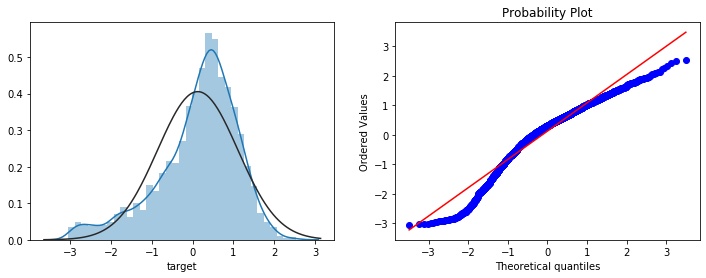

In [4]:
# target标签数据分析，分位数
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
sns.distplot(data_all.target.dropna() , fit = stats.norm)
plt.subplot(1,2,2)
_ = stats.probplot(data_all.target.dropna(), plot = plt)

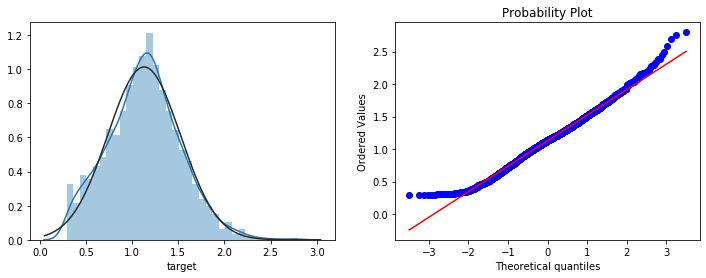

In [5]:
# 对target进行对数变换，使数据更符合正态性
sp = data_train.target
data_train.target1 = np.power(1.5 ,sp)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(data_train.target1.dropna(),fit = stats.norm)
plt.subplot(1,2,2)
_ = stats.probplot(data_train.target1.dropna(), plot = plt)

In [6]:
# 获取训练和测试数据
def get_training_data():
    from sklearn.model_selection import train_test_split
    df_train = data_all[data_all['origin'] == 'train']
    df_train['label'] = data_train.target1

    X = df_train.drop(['origin', 'target', 'label'], axis = 1)
    y = df_train['target']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 0)
    return X_train, X_valid, y_train, y_valid

def get_test_data():
    df_test = data_all[data_all['origin'] == 'test'].reset_index(drop = True)
    return df_test.drop(['origin', 'target'], axis = 1)

# 评分函数
from sklearn.metrics import make_scorer

def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff ** 2)
    n = len(y_pred)

    return np.sqrt(sum_sq / (n - 1))

def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

rmse_scorer = make_scorer(rmse, greater_is_better = False)
mse_scorer = make_scorer(mse, greater_is_better = False)

## 获取异常数据，并画图

In [7]:
# function to detect outliers based on the predictions of a model
def find_outliers(model, X, y, sigma = 3):

    # predict y values using model
    try:
        y_pred = pd.Series(model.predict(X), index = y.index)
    # if predicting fails, try fitting the model first
    except:
        model.fit(X, y)
        y_pred = pd.Series(model.predict(X), index = y.index)
        
    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()

    # calculate z statistic, define outliers to be where |z|>sigma
    z = (resid - mean_resid) / std_resid    
    outliers = z[abs(z) > sigma].index
    
    # print and plot the results
    print('R2 = ', model.score(X,y))
    print('rmse = ', rmse(y, y_pred))
    print("mse = ", mse(y,y_pred))
    print('---------------------------------------')
    print('mean of residuals: ', mean_resid)
    print('std of residuals: ', std_resid)
    print('---------------------------------------')
    print(len(outliers), 'outliers: ')
    print(outliers.tolist())

    plt.figure(figsize=(15, 5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y, y_pred, '.')
    plt.plot(y.loc[outliers], y_pred.loc[outliers], 'ro')
    plt.legend(['Accepted', 'Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred')

    ax_132=plt.subplot(1,3,2)
    plt.plot(y, y-y_pred, '.')
    plt.plot(y.loc[outliers], y.loc[outliers] - y_pred.loc[outliers], 'ro')
    plt.legend(['Accepted', 'Outlier'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred')

    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins = 50,ax = ax_133)
    z.loc[outliers].plot.hist(color = 'r',bins = 50,ax = ax_133)
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('z')
    
    plt.savefig('outliers.png')
    
    return outliers

R2 =  0.8682314460372129
rmse =  0.35367758232277635
mse =  0.12502593820886776
---------------------------------------
mean of residuals:  -2.291860692101016e-16
std of residuals:  0.353677582322776
---------------------------------------
24 outliers: 
[2697, 2160, 1458, 2696, 1069, 1145, 884, 1164, 1310, 2668, 2807, 1704, 1874, 2279, 777, 2002, 691, 348, 2645, 2769, 2528, 2159, 2863, 2647]


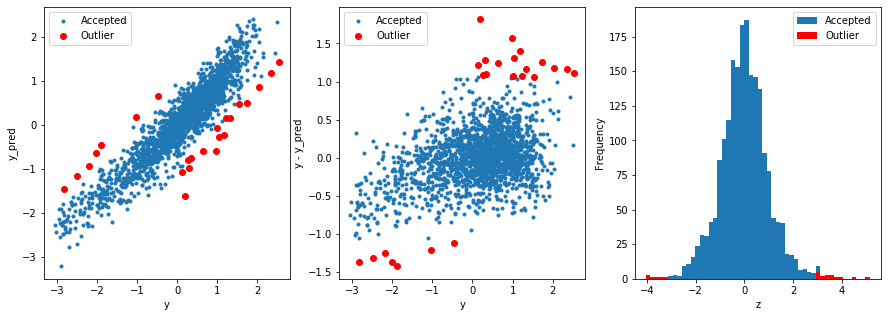

In [8]:
# 获取数据
X_train, X_valid, y_train, y_valid = get_training_data()
test = get_test_data()

# 利用Ridge寻找异常值
outliers = find_outliers(Ridge(), X_train, y_train)

#移除异常值
X_outliers = X_train.loc[outliers]
y_outliers = y_train.loc[outliers]
X_t = X_train.drop(outliers)
y_t = y_train.drop(outliers)

def get_trainning_data_omitoutliers():
    y1 = y_t.copy()
    X1 = X_t.copy()
    return X1, y1

X_train, y_train = get_trainning_data_omitoutliers()

## 利用网格搜索进行模型训练

In [9]:
def train_model(model, param_grid = [], X = [], y = [], splits = 5, repeats = 5):
    
    # create cross-validation method
    rkfold = RepeatedKFold(n_splits = splits, n_repeats = repeats)
    
    # perform a grid search if param_grid given
    if len(param_grid) > 0:
        # setup grid search parameters
        gsearch = GridSearchCV(model, param_grid, cv = rkfold,
                               scoring = "neg_mean_squared_error",
                               verbose = 1, return_train_score = True, n_jobs = -1)

        # search the grid
        gsearch.fit(X, y)

        # extract best model from the grid
        model = gsearch.best_estimator_        
        best_idx = gsearch.best_index_

        # get cv-scores for best model
        grid_results = pd.DataFrame(gsearch.cv_results_)       
        cv_mean = abs(grid_results.loc[best_idx, 'mean_test_score'])
        cv_std = grid_results.loc[best_idx, 'std_test_score']

    # no grid search, just cross-val score for given model    
    else:
        grid_results = []
        cv_results = cross_val_score(model, X, y, scoring = "neg_mean_squared_error", cv = rkfold)
        cv_mean = abs(np.mean(cv_results))
        cv_std = np.std(cv_results)
    
    # combine mean and std cv-score in to a pandas series
    cv_score = pd.Series({'mean' : cv_mean, 'std' : cv_std})

    # predict y using the fitted model
    y_pred = model.predict(X)
    
    # print stats on model performance         
    print('----------------------')
    print(model)
    print('----------------------')
    print('rmse = ',rmse(y, y_pred))
    print('mse = ',mse(y, y_pred))
    print('cross_val: mean = ',cv_mean,', std = ',cv_std)

    return model, cv_score, grid_results

In [10]:
# 模型保存
opt_models = dict()
score_models = pd.DataFrame(columns = ['mean', 'std'])

# CV参数
splits = 5
repeats = 5

## Ridge回归

Fitting 25 folds for each of 7 candidates, totalling 175 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.0s
----------------------
Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------
rmse =  0.3248716704716743
mse =  0.10548875219880423
cross_val: mean =  0.11096793083287827 , std =  0.006923127981159296
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    2.4s finished


Text(0, 0.5, 'score')

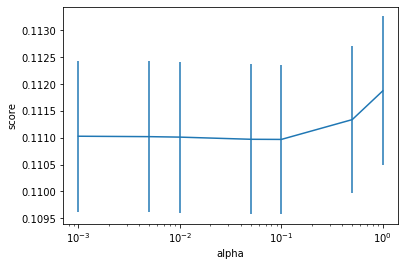

In [11]:
model = 'Ridge'

opt_models[model] = Ridge()
alph_range = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
param_grid = {'alpha': alph_range}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], 
                                                        param_grid = param_grid, 
                                                        X = X_train, y = y_train,
                                                        splits = splits, repeats = repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

fig, ax = plt.subplots()
plt.errorbar(alph_range, 
             abs(grid_results['mean_test_score']),
             abs(grid_results['std_test_score']) / np.sqrt(splits * repeats))
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('score')

## Lasso回归

Fitting 25 folds for each of 7 candidates, totalling 175 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
----------------------
Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
rmse =  0.32495175474711735
mse =  0.10554076677757067
cross_val: mean =  0.11039031377239328 , std =  0.0077921189536568815
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    0.5s finished


Text(0, 0.5, 'score')

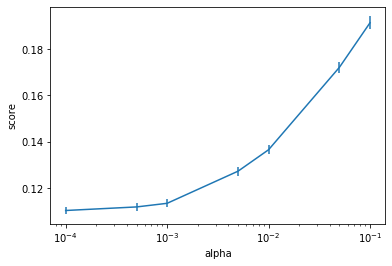

In [12]:
model = 'Lasso'

opt_models[model] = Lasso()
alph_range = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
param_grid = {'alpha': alph_range}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], 
                                                        param_grid = param_grid, 
                                                        X = X_train, y = y_train,
                                                        splits = splits, repeats = repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

fig, ax = plt.subplots()
plt.errorbar(alph_range, 
             abs(grid_results['mean_test_score']),
             abs(grid_results['std_test_score']) / np.sqrt(splits * repeats))
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('score')

## ElasticNet回归

In [14]:
model ='ElasticNet'
opt_models[model] = ElasticNet()

param_grid = {'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01],
              'l1_ratio': np.arange(0.2,1.0,0.2),
              'max_iter':[1000, 10000, 100000]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], 
                                                        param_grid = param_grid, 
                                                        X = X_train, y = y_train,
                                                        splits = splits, repeats = repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

Fitting 25 folds for each of 60 candidates, totalling 1500 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 734 tasks      | elapsed:    4.0s
----------------------
ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.2,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
----------------------
rmse =  0.3250373217760494
mse =  0.10559635656109403
cross_val: mean =  0.11053090737408464 , std =  0.008795028690088169
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    5.3s finished


## KNN

Fitting 25 folds for each of 8 candidates, totalling 200 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.4s
----------------------
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')
----------------------
rmse =  0.5234854584660884
mse =  0.2738998008763145
cross_val: mean =  0.33639584917376064 , std =  0.03346568436776578
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.8s finished


Text(0, 0.5, 'score')

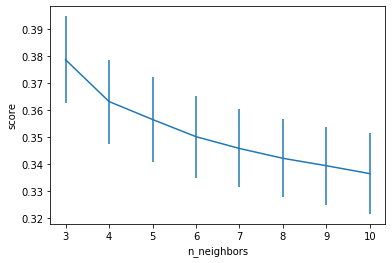

In [15]:
model = 'KNeighbors'
opt_models[model] = KNeighborsRegressor()

param_grid = {'n_neighbors':np.arange(3,11,1)}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], 
                                                        param_grid = param_grid, 
                                                        X = X_train, y = y_train,
                                                        splits = splits, repeats = repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(np.arange(3,11,1), 
             abs(grid_results['mean_test_score']),
             abs(grid_results['std_test_score']) / np.sqrt(splits * 1))
plt.xlabel('n_neighbors')
plt.ylabel('score')

## GBDT

In [17]:
model = 'GradientBoosting'
opt_models[model] = GradientBoostingRegressor()

param_grid = {'n_estimators':[500, 1000],
              'max_depth':[2, 3, 4],
              'min_samples_split':[5, 6, 7]
              }

opt_models[model], cv_score, grid_results = train_model(opt_models[model], 
                                                        param_grid = param_grid, 
                                                        X = X_train, y = y_train,
                                                        splits = splits, repeats = 1)

cv_score.name = model
score_models = score_models.append(cv_score)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   52.1s finished
----------------------
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=6,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
----------------------
rmse =  0.20231844440194943
mse =  0.0

## XGB

In [18]:
model = 'XGB'
opt_models[model] = XGBRegressor()

param_grid = {'n_estimators':[250, 500, 750, 1000],
              'max_depth':[2, 3, 4]
              }

opt_models[model], cv_score, grid_results = train_model(opt_models[model], 
                                                        param_grid = param_grid, 
                                                        X = X_train, y = y_train,
                                                        splits = splits, repeats = 1)

cv_score.name = model
score_models = score_models.append(cv_score)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   26.2s finished
[20:48:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
----------------------
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=250,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
----------------------
rmse =  0.12326356924873762
mse =  0.01518629913763692
cross_val: mean =  0.103696112

## RandomForest

In [19]:
model = 'RandomForest'
opt_models[model] = RandomForestRegressor()

param_grid = {'n_estimators':[250, 500, 750, 1000],
              'max_features':[8, 16, 24, 32],
              }

opt_models[model], cv_score, grid_results = train_model(opt_models[model], 
                                                        param_grid = param_grid, 
                                                        X = X_train, y = y_train,
                                                        splits = splits, repeats = 1)

cv_score.name = model
score_models = score_models.append(cv_score)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.6min finished
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=16, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
rmse =  0.11914781627979604
mse =  0.014189093360035586
cross_val: mean =  0.1074889879296872 , std =  0.008944095526368673


## 多模型bagging

In [38]:
def model_bagging_predict(test_data, test_y = [], stack = False):
    i = 0
    y_predict_total = np.zeros((test_data.shape[0], ))
    for model in opt_models.keys():
        if model in ['GradientBoosting', 'XGB', 'RandomForest']:
            y_predict = opt_models[model].predict(test_data)
            y_predict_total += y_predict
            i += 1
            if len(test_y) > 0:
                print("{}_mse:".format(model), mean_squared_error(y_predict, test_y))
        
    y_predict_mean = np.round(y_predict_total / i, 3)
    if len(test_y) > 0:
        print("bagging_mean_mse:", mean_squared_error(y_predict_mean, test_y))
    else:
        y_predict_mean = pd.Series(y_predict_mean)
        return y_predict_mean

In [39]:
model_bagging_predict(X_valid, y_valid)

GradientBoosting_mse: 0.1209758825808782
XGB_mse: 0.11986669946667873
RandomForest_mse: 0.12259964826549255
bagging_mean_mse: 0.11531094694348328


In [40]:
bagging_res = model_bagging_predict(test)
bagging_res.to_csv('data/bagging_res.txt', sep = '\t', index = 0)